In [1]:
import pandas as pd
import sentence_transformers 
import datasets
import squarify
import matplotlib.pyplot as plt

from hf_search.data import make_hf_dataset

In [2]:
plt.style.use("dark_background")

# Huggingface models exploration

## Loading data

We downloaded information on models on June 2022 and also tried to download READMES.

In [3]:
from sklearn import decomposition, pipeline, feature_extraction
from mlutil import topic_modeling
from mlutil.visualization import word_clouds, treemaps


def test_truncate_counts():
    x = pd.Series(["one"] * 10 + ["two"] * 1)
    x_counts = x.value_counts()
    x_counts_truncated = truncate_counts(x_counts, 2)
    assert x_counts_truncated.shape[0] == 2
    assert "other" in x_counts_truncated.index
    assert "two" not in x_counts_truncated.index

In [4]:
raw_models_df = pd.read_csv("../data/interim/models_with_readmes.csv")

In [5]:
raw_models_df.shape

(50839, 11)

In [6]:
raw_models_df['pipeline_tag'].isna().mean()

0.32614724915911014

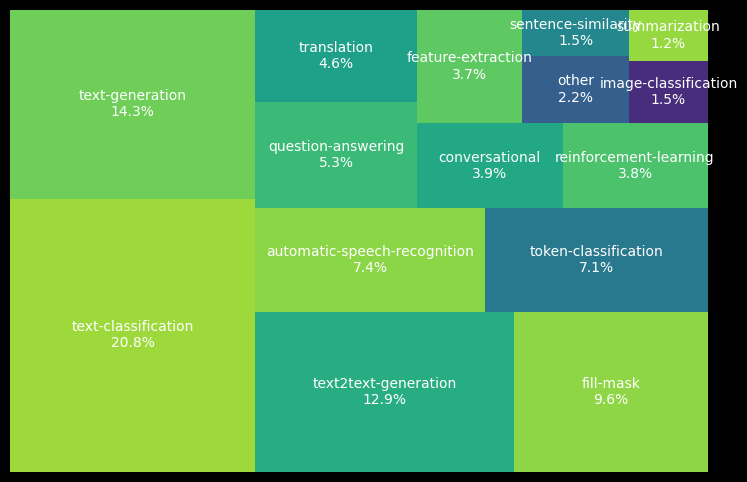

In [7]:
treemaps.plot_treemap_with_counts(raw_models_df['pipeline_tag'], 200, use_percentages=True)
plt.show()

In [8]:
models_df = raw_models_df.dropna(subset=['readme'])

It seems like most models are classification models. But when we only select models that have README, the proportion changes.

Most likely this is due to the fact that it is easy to play with classification models, so people upload their small experiments which remain undocumented.

This is also corroborated by the fact that there are more NaNs in pipeline tags for models without READMEs.

In [9]:
na_raw_pipeline_tags = raw_models_df['pipeline_tag'].isna().mean()
na_pipeline_tags = models_df['pipeline_tag'].isna().mean()

In [10]:
na_raw_pipeline_tags

0.32614724915911014

In [11]:
na_pipeline_tags

0.10258199581297976

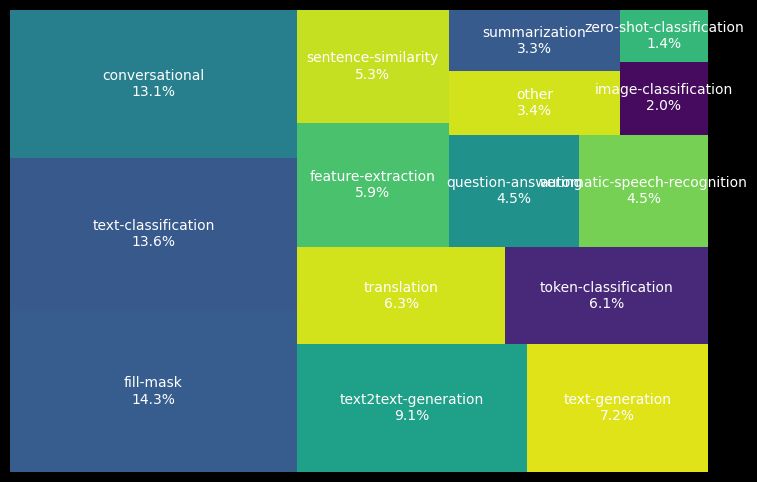

In [12]:
treemaps.plot_treemap_with_counts(models_df['pipeline_tag'], 20, use_percentages=True)
plt.show()

## Topic modeling

In [13]:
nmf = decomposition.NMF(n_components=10, alpha=0.01)
topic_modeling_pipeline = topic_modeling.create_topic_modeling_pipeline()

In [14]:
texts = models_df['readme']

topic_modeling_pipeline.fit(texts)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words='english',
                                 tokenizer=<mlutil.textmining.LemmaTokenizer object at 0x7f1a281e0790>)),
                ('nmf', NMF(n_components=10))])

In [15]:
top_topic_words = topic_modeling.top_topic_words(topic_modeling_pipeline, n_words=10)

In [16]:
top_topic_words.iloc[:,:5]

,0,1,2,3,4
topic_0,model,text,language,wa,task
topic_1,conversational,dialogpt,tag,rick,model
topic_2,sentence,embeddings,model,sentence-transformers](https://www.sbert.net,sentence-transformers
topic_3,translation,opus,test,set,normalization
topic_4,needed,information,training,loss,hyperparameters
topic_5,image,model,vision,resolution,class
topic_6,speech,wer,type,cer,import
topic_7,potter,harry,dialogpt,conversational,tag
topic_8,multiberts,reproduction,bert,bert-base,model
topic_9,nan,rmse,mae,r2,blame::a


In [17]:
dominant_topics = topic_modeling_pipeline.transform(texts).argmax(axis=1)

We are able to uncover interesting clusters (topics)

### topic0 ###
model
text
language
wa
task
bert
score
token
sequence
use


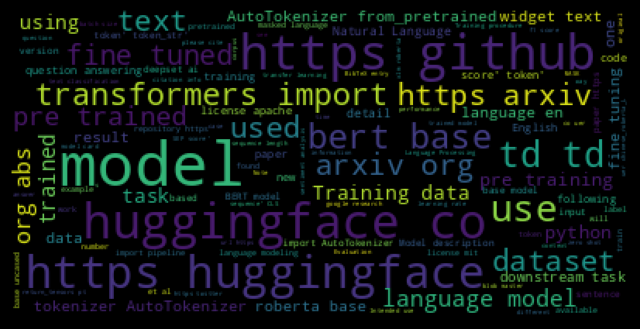

### topic1 ###
conversational
dialogpt
tag
rick
model
morty
awesome
bot
michael
scott


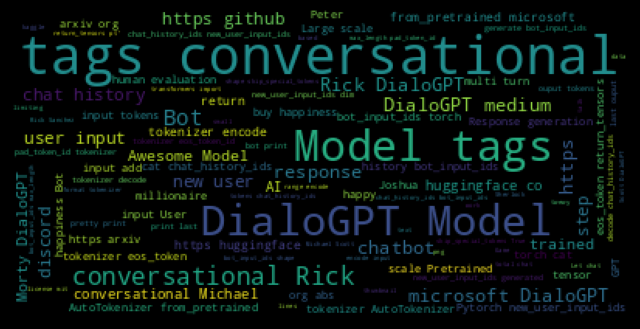

### topic2 ###
sentence
embeddings
model
sentence-transformers](https://www.sbert.net
sentence-transformers
false
pooling
sentence-similarity
like
sentencetransformer


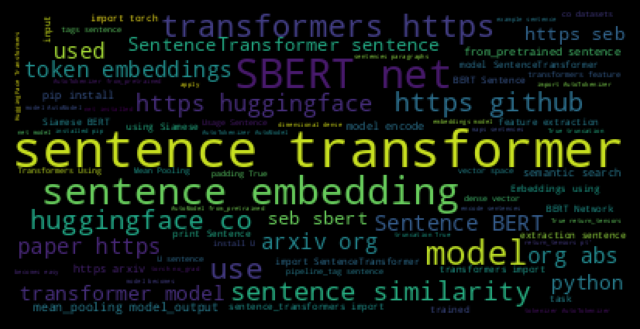

### topic3 ###
translation
opus
test
set
normalization
bleu
target
transformer-align
sentencepiece
chr-f


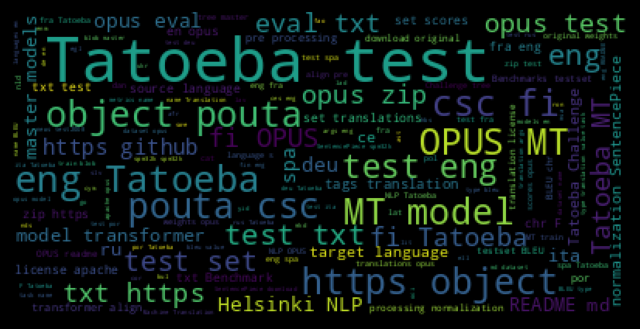

### topic4 ###
needed
information
training
loss
hyperparameters
result
accuracy
evaluation
following
version


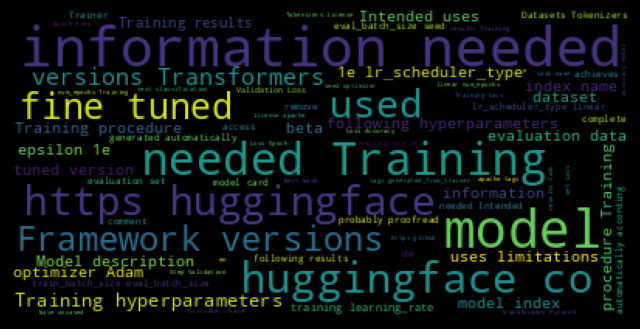

### topic5 ###
image
model
vision
resolution
class
transformer
imagenet
segformer
team
encoder


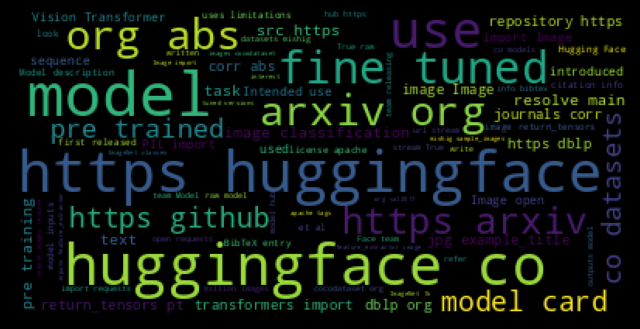

### topic6 ###
speech
wer
type
cer
import
test
automatic-speech-recognition
value
audio
recognition


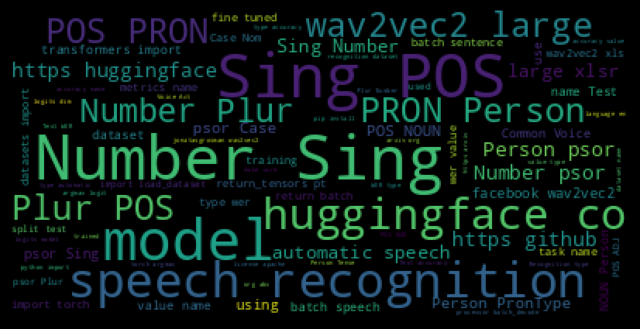

### topic7 ###
potter
harry
dialogpt
conversational
tag
model
dialoggpt
bot
dialgpt
dialog-gpt


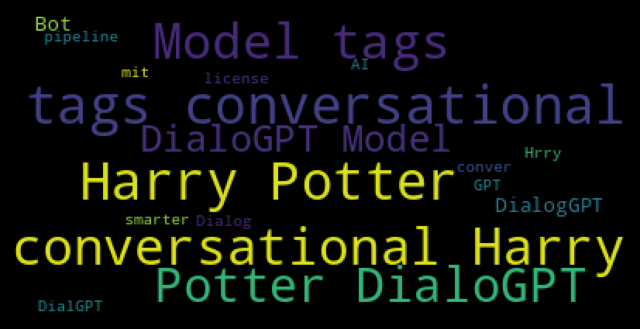

### topic8 ###
multiberts
reproduction
bert
bert-base
model
original
difference
uncased](https://github.com/google-research/bert
checkpoint
turc


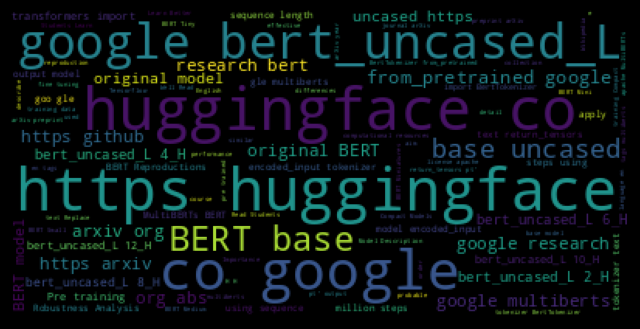

### topic9 ###
nan
rmse
mae
r2
blame::a
focus::a
cause::a
rsa
neighbor
rank


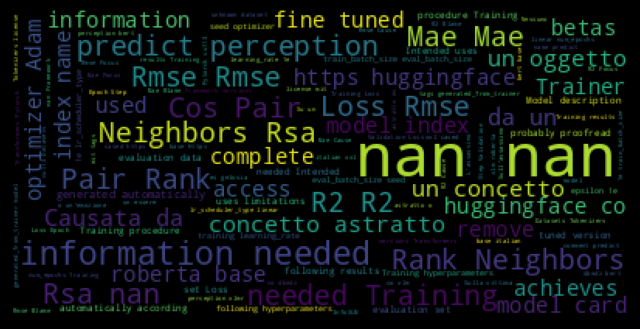

In [22]:
for i in set(dominant_topics):
    print(f"### topic{i} ###")
    for w in top_topic_words.iloc[i].tolist():
        print(w)
    word_clouds.show_word_cloud_from_texts(texts[dominant_topics == i])